In [1]:
import math
import os
import pickle
import pandas as pd

import numpy as np

from matplotlib import pyplot as plt

import torch

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# https://github.com/rdbraatz/data-driven-prediction-of-battery-cycle-life-before-capacity-degradation/blob/master/Load%20Data.ipynb

remove_keys = [
  # FOLLOWS THE ORIGINAL REPO
  # remove batteries that do not reach 80% capacity
  'b1c8', 'b1c10', 'b1c12', 'b1c13', 'b1c22',      
  # remove batteries from batch 2 that are moved to batch 1
  'b2c7', 'b2c8', 'b2c9', 'b2c15', 'b2c16',      
  # remove noisy channels from batch3
  'b3c37', 'b3c2', 'b3c23', 'b3c32', 'b3c42', 'b3c43',
  
  # NEWLY DELETED HERE
  # remove outlier with abnormal capacity
  'b1c0', 'b1c18', 'b2c12', 'b2c44'
]
# There are four cells from batch1 that carried into batch2, we'll remove the data from batch2
# and put it with the correct cell from batch1
batch2_keys = ['b2c7', 'b2c8', 'b2c9', 'b2c15', 'b2c16']
batch1_keys = ['b1c0', 'b1c1', 'b1c2', 'b1c3', 'b1c4']
add_len = [662, 981, 1060, 208, 482]

temperature_feature_interval = 1
current_feature_interval = 1

cap_outlier_diff_threshold = 0.015

curve_ratio_min = 0.5
curve_ratio_max = 0.99
curve_ratio_steps = 9
curve_ratio_digits = 2
curve_ratio_step_size = (curve_ratio_max - curve_ratio_min) / curve_ratio_steps

In [3]:
data_dir_path = '/Users/keilongwong/Library/CloudStorage/OneDrive-個人/IPM PhD/Thesis/Data/Stanford University battery dataset'
batch1 = pickle.load(open(os.path.join(data_dir_path,'batch1.pkl'), 'rb'))
batch2 = pickle.load(open(os.path.join(data_dir_path,'batch2.pkl'), 'rb'))
batch3 = pickle.load(open(os.path.join(data_dir_path,'batch3.pkl'), 'rb'))

for i, bk in enumerate(batch1_keys):
  batch1[bk]['cycle_life'] = batch1[bk]['cycle_life'] + add_len[i]
  for j in batch1[bk]['summary'].keys():
    if j == 'cycle':
      batch1[bk]['summary'][j] = np.hstack((batch1[bk]['summary'][j], batch2[batch2_keys[i]]['summary'][j] + len(batch1[bk]['summary'][j])))
    else:
      batch1[bk]['summary'][j] = np.hstack((batch1[bk]['summary'][j], batch2[batch2_keys[i]]['summary'][j]))
  last_cycle = len(batch1[bk]['cycles'].keys())
  for j, jk in enumerate(batch2[batch2_keys[i]]['cycles'].keys()):
    batch1[bk]['cycles'][str(last_cycle + j)] = batch2[batch2_keys[i]]['cycles'][jk]
    
batch = {**batch1, **batch2, **batch3}
for key in remove_keys:
  del batch[key]

In [4]:
max_temps = []
min_temps = []
for key in batch.keys():
  max_temps.append(np.max(batch[key]['summary']['Tmax']))
  min_temps.append(np.min(batch[key]['summary']['Tmin'][np.nonzero(batch[key]['summary']['Tmin'])]))
max_temp = np.max(max_temps)
min_temp = np.min(min_temps)

max_currents = []
min_currents = []
for key in batch.keys():
  for cycle in batch[key]['cycles'].keys():
    max_currents.append(np.max(batch[key]['cycles'][cycle]['I']))
    min_currents.append(np.min(batch[key]['cycles'][cycle]['I']))
max_current = np.max(max_currents)
min_current = np.min(min_currents)

In [5]:
batch.keys()

dict_keys(['b1c1', 'b1c2', 'b1c3', 'b1c4', 'b1c5', 'b1c6', 'b1c7', 'b1c9', 'b1c11', 'b1c14', 'b1c15', 'b1c16', 'b1c17', 'b1c19', 'b1c20', 'b1c21', 'b1c23', 'b1c24', 'b1c25', 'b1c26', 'b1c27', 'b1c28', 'b1c29', 'b1c30', 'b1c31', 'b1c32', 'b1c33', 'b1c34', 'b1c35', 'b1c36', 'b1c37', 'b1c38', 'b1c39', 'b1c40', 'b1c41', 'b1c42', 'b1c43', 'b1c44', 'b1c45', 'b2c0', 'b2c1', 'b2c2', 'b2c3', 'b2c4', 'b2c5', 'b2c6', 'b2c10', 'b2c11', 'b2c13', 'b2c14', 'b2c17', 'b2c18', 'b2c19', 'b2c20', 'b2c21', 'b2c22', 'b2c23', 'b2c24', 'b2c25', 'b2c26', 'b2c27', 'b2c28', 'b2c29', 'b2c30', 'b2c31', 'b2c32', 'b2c33', 'b2c34', 'b2c35', 'b2c36', 'b2c37', 'b2c38', 'b2c39', 'b2c40', 'b2c41', 'b2c42', 'b2c43', 'b2c45', 'b2c46', 'b2c47', 'b3c0', 'b3c1', 'b3c3', 'b3c4', 'b3c5', 'b3c6', 'b3c7', 'b3c8', 'b3c9', 'b3c10', 'b3c11', 'b3c12', 'b3c13', 'b3c14', 'b3c15', 'b3c16', 'b3c17', 'b3c18', 'b3c19', 'b3c20', 'b3c21', 'b3c22', 'b3c24', 'b3c25', 'b3c26', 'b3c27', 'b3c28', 'b3c29', 'b3c30', 'b3c31', 'b3c33', 'b3c34', 'b3c3

In [6]:
batch['b1c1']['cycles']['3']['t']

array([0.00000000e+00, 2.71166667e-03, 3.15333333e-03, ...,
       5.43692000e+01, 5.43778267e+01, 5.43858433e+01])

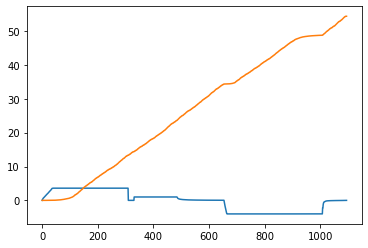

In [7]:
plt.plot(batch['b1c1']['cycles']['333']['I'])
plt.plot(batch['b1c1']['cycles']['333']['t'])

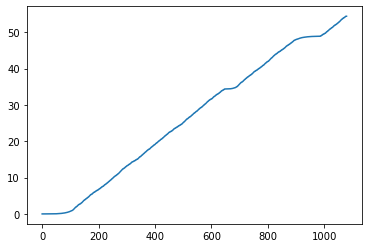

In [8]:
plt.plot(batch['b1c1']['cycles']['3']['t'])

In [9]:
data_path = '/Users/keilongwong/Library/CloudStorage/OneDrive-個人/IPM PhD/Thesis/Data/Samsung INR21700 30T 3Ah Li-ion Battery Data'

temp_to_test = ['40degC', '25degC', '10degC']

# loop all csv in data_path and append all rows in one dataframe
df = pd.DataFrame()
for dir in os.listdir(data_path):
    if not os.path.isdir(os.path.join(data_path, dir)):
        continue
    if dir not in temp_to_test:
        continue
    for file in os.listdir(os.path.join(data_path, dir)):
        if not file.endswith('.csv'):
            continue
        file_path = os.path.join(data_path, dir, file)
        # print(file_path)
        time_stamp_line_idx = 0

        with open(file_path) as f:
            for i, line in enumerate(f):
                if 'Time Stamp' in line:
                    time_stamp_line_idx = i
                    break
        
        new_df = pd.read_csv(file_path, 
                                skiprows=time_stamp_line_idx + 2, 
                                header=None,
                                index_col=False,
                                names=['Time Stamp',
                                    'Step',
                                    'Status',
                                    'Prog Time',
                                    'Step Time',
                                    'Cycle',
                                    'Cycle Level',
                                    'Procedure',
                                    'Voltage',
                                    'Current',
                                    'Temperature',
                                    'Capacity',
                                    'WhAccu',
                                    'Cnt'],
                                )
        new_df = new_df.drop_duplicates()
        
        # remove date only rows
        new_df = new_df[new_df['Time Stamp'].str.len() > 10]
        
        # print(file_path)
        new_df['Timestamp'] = pd.to_datetime(new_df['Time Stamp'], format='%m/%d/%Y %I:%M:%S %p').apply(lambda x: x.timestamp())
        
        # new_df['Timestamp'] = pd.to_datetime(new_df['Time Stamp']).apply(lambda x: x.timestamp())
        
        new_df['Exp Temperature'] = dir
        new_df['Cycle Name'] = file[:-4]
        new_df['Exp Name'] = dir + ': ' + file[:-4]
        
        new_df['Index'] = new_df.index
        
        df = pd.concat([df, new_df])
                

df = df[df['Status'].isin([
                           'DCH', 
                           'PAU', 
                           'CHA', 
                        #    'STO',
                           'TABLE', 
                        #    'MSG'
                           ])]
                
df.sort_values(by=['Timestamp', 'Index'], inplace=True)

df['Status Consecutive'] = (df['Status'] != df['Status'].shift()).cumsum()
df['Status Unique'] = df['Status'] + df['Status Consecutive'].astype(str)

cycle_count = 0
for key, group in df.groupby('Exp Name', sort=False):
  df.loc[group.index, 'Cycle Num'] = cycle_count
  cycle_count += 1      
  
df.reset_index(drop=True, inplace=True)
df['Index'] = df.index


/var/folders/h8/8jpw1q2n08b3k_kml79456t40000gn/T/ipykernel_48689/3499996509.py:25: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  new_df = pd.read_csv(file_path,
/var/folders/h8/8jpw1q2n08b3k_kml79456t40000gn/T/ipykernel_48689/3499996509.py:25: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  new_df = pd.read_csv(file_path,
/var/folders/h8/8jpw1q2n08b3k_kml79456t40000gn/T/ipykernel_48689/3499996509.py:25: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  new_df = pd.read_csv(file_path,
/var/folders/h8/8jpw1q2n08b3k_kml79456t40000gn/T/ipykernel_48689/3499996509.py:25: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  new_df = pd.read_csv(file_path,
/var/folders/h8/8jpw1q2n08b3k_kml79456t4

In [10]:
df.to_csv('all_data.csv', index=False)

In [11]:
df

,Time Stamp,Step,Status,Prog Time,Step Time,Cycle,Cycle Level,Procedure,Voltage,Current,...,WhAccu,Cnt,Timestamp,Exp Temperature,Cycle Name,Exp Name,Index,Status Consecutive,Status Unique,Cycle Num
0,2/24/2019 5:19:40 PM,24,DCH,39:01:33.780,00:00:59.999,0,0,Samsung30T_NN_Char,4.17335,-0.15069,...,-0.01057,22.0,1.551029e+09,40degC,697_C20DisCh,40degC: 697_C20DisCh,0,1,DCH1,102.0
1,2/24/2019 5:20:40 PM,24,DCH,39:02:33.789,00:02:00.008,0,0,Samsung30T_NN_Char,4.17065,-0.15325,...,-0.02116,22.0,1.551029e+09,40degC,697_C20DisCh,40degC: 697_C20DisCh,1,1,DCH1,102.0
2,2/24/2019 5:21:40 PM,24,DCH,39:03:33.786,00:03:00.005,0,0,Samsung30T_NN_Char,4.16795,-0.15069,...,-0.03174,22.0,1.551029e+09,40degC,697_C20DisCh,40degC: 697_C20DisCh,2,1,DCH1,102.0
3,2/24/2019 5:22:40 PM,24,DCH,39:04:33.790,00:04:00.009,0,0,Samsung30T_NN_Char,4.16542,-0.15069,...,-0.04230,22.0,1.551029e+09,40degC,697_C20DisCh,40degC: 697_C20DisCh,3,1,DCH1,102.0
4,2/24/2019 5:23:40 PM,24,DCH,39:05:33.795,00:05:00.014,0,0,Samsung30T_NN_Char,4.16306,-0.15325,...,-0.05287,22.0,1.551029e+09,40degC,697_C20DisCh,40degC: 697_C20DisCh,4,1,DCH1,102.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1464327,3/31/2019 12:39:45 AM,81,PAU,35:38:22.027,00:09:59.606,0,0,Samsung30T_CyclesB,4.05684,0.00000,...,-1.62428,67.0,1.553993e+09,10degC,756_PausCycl,10degC: 756_PausCycl,1464327,1525,PAU1525,102.0
1464328,3/31/2019 12:39:45 AM,81,PAU,35:38:22.136,00:09:59.715,0,0,Samsung30T_CyclesB,4.05684,0.00000,...,-1.62428,67.0,1.553993e+09,10degC,756_PausCycl,10degC: 756_PausCycl,1464328,1525,PAU1525,102.0
1464329,3/31/2019 12:39:46 AM,81,PAU,35:38:22.228,00:09:59.807,0,0,Samsung30T_CyclesB,4.05684,0.00000,...,-1.62428,67.0,1.553993e+09,10degC,756_PausCycl,10degC: 756_PausCycl,1464329,1525,PAU1525,102.0
1464330,3/31/2019 12:39:46 AM,81,PAU,35:38:22.327,00:09:59.906,0,0,Samsung30T_CyclesB,4.05684,0.00000,...,-1.62428,67.0,1.553993e+09,10degC,756_PausCycl,10degC: 756_PausCycl,1464330,1525,PAU1525,102.0


In [12]:
# test_df = pd.read_csv('/home/keilong/Downloads/Samsung INR21700 30T 3Ah Li-ion Battery Data/40degC/697_Dis_2C.csv', 
#                                 skiprows=time_stamp_line_idx + 2, 
#                                 header=None,
#                                 index_col=False,
#                                 names=['Time Stamp',
#                                     'Step',
#                                     'Status',
#                                     'Prog Time',
#                                     'Step Time',
#                                     'Cycle',
#                                     'Cycle Level',
#                                     'Procedure',
#                                     'Voltage',
#                                     'Current',
#                                     'Temperature',
#                                     'Capacity',
#                                     'WhAccu',
#                                     'Cnt'],)

# test_df.index.name = 'Index'
# test_df['Timestamp'] = pd.to_datetime(test_df['Time Stamp']).apply(lambda x: x.timestamp())

# test_df.sort_values(by=['Timestamp', 'Index'], inplace=True)

# test_df.to_csv('test.csv', index=False)

In [13]:
cycle_configs = cycle_configs = [
  [('40degC: 697_C20DisCh', 'ALL'), ('40degC: 697_C20DisCh', 'CHA3')],
  [('40degC: 697_Dis_0p5C', 'ALL'), ('40degC: 697_Dis_0p5C', 'CHA7')],
  [('40degC: 697_Dis_2C', ['DCH9', 'PAU10', 'CHA11']), ('40degC: 697_Dis_2C', 'CHA11')],
  # very short charging cycle
  # [('40degC: 697_Dis_2C', ['PAU14', 'DCH15', 'PAU16', 'CHA17']), ('40degC: 697_Dis_2C', 'CHA17')],
  [('40degC: 710_UDDS', 'ALL'), ('40degC: 710_Charge3', 'CHA467')],
  [('40degC: 710_HWFET', 'ALL'), ('40degC: 710_Charge4', 'CHA471')],
  [('40degC: 710_LA92', 'ALL'), ('40degC: 710_Charge5', 'CHA475')],
  [('40degC: 710_US06', 'ALL'), ('40degC: 710_Charge6', 'CHA479')],
  [('40degC: 710_Mixed1', 'ALL'), ('40degC: 710_Charge7', 'CHA483')],
  [('40degC: 710_Mixed2', 'ALL'), ('40degC: 710_Charge8', 'CHA487')],
  [('40degC: 722_Cap_1C', 'ALL'), ('40degC: 722_Charge10', 'CHA493')],
  [('40degC: 722_Mixed3', 'ALL'), ('40degC: 722_Charge11', 'CHA497')],
  [('40degC: 722_Mixed4', 'ALL'), ('40degC: 722_Charge12', 'CHA501')],
  [('40degC: 722_Mixed5', 'ALL'), ('40degC: 722_Charge13', 'CHA505')],
  [('40degC: 722_Mixed6', 'ALL'), ('40degC: 722_Charge14', 'CHA509')],
  [('40degC: 722_Mixed7', 'ALL'), ('40degC: 722_Charge15', 'CHA513')],
  [('40degC: 722_Mixed8', 'ALL'), ('40degC: 722_Charge16', 'CHA517')],

  # abnormally high charged capacity
  # [('25degC: 729_C20DisCh', 'ALL'), ('25degC: 729_C20DisCh', 'CHA1863')],
  [('25degC: 729_Dis_0p5C', 'ALL'), ('25degC: 729_Dis_0p5C', 'CHA971')],
  [('25degC: 729_Dis_2C', ['DCH973', 'PAU974', 'CHA975']), ('25degC: 729_Dis_2C', 'CHA975')],
  [('25degC: 729_Dis_2C', ['PAU976', 'DCH977', 'PAU978', 'CHA979']), ('25degC: 729_Dis_2C', 'CHA979')],
  [('25degC: 734_Cap_1C', 'ALL'), ('25degC: 734_Charge2', 'CHA985')],
  [('25degC: 734_UDDS', 'ALL'), ('25degC: 734_Charge3', 'CHA989')],
  [('25degC: 734_HWFET', 'ALL'), ('25degC: 734_Charge4', 'CHA993')],
  [('25degC: 734_LA92', 'ALL'), ('25degC: 734_Charge5', 'CHA997')],
  [('25degC: 734_US06', 'ALL'), ('25degC: 734_Charge6', 'CHA1001')],
  [('25degC: 734_Mixed1', 'ALL'), ('25degC: 734_Charge7', 'CHA1005')],
  [('25degC: 734_Mixed2', 'ALL'), ('25degC: 734_Charge8', 'CHA1009')],
  [('25degC: 740_Mixed3', 'ALL'), ('25degC: 740_Charge11', 'CHA1017')],
  [('25degC: 740_Mixed4', 'ALL'), ('25degC: 740_Charge12', 'CHA1021')],
  [('25degC: 740_Mixed5', 'ALL'), ('25degC: 740_Charge13', 'CHA1025')],
  [('25degC: 740_Mixed6', 'ALL'), ('25degC: 740_Charge14', 'CHA1029')],
  [('25degC: 740_Mixed7', 'ALL'), ('25degC: 740_Charge15', 'CHA1033')],
  [('25degC: 740_Mixed8', 'ALL'), ('25degC: 740_Charge16', 'CHA1037')],

  # abnormally high charged capacity
  # [('10degC: 746_C20DisCh', 'ALL'), ('10degC: 746_C20DisCh', 'CHA2757')],
  [('10degC: 746_Dis_0p5C', 'ALL'), ('10degC: 746_Dis_0p5C', 'CHA1457')],
  [('10degC: 746_Dis_2C', ['DCH1459', 'PAU1460', 'CHA1461']), ('10degC: 746_Dis_2C', 'CHA1461')],
  [('10degC: 746_Dis_2C', ['PAU1462', 'DCH1463', 'PAU1464']), ('10degC: 752_Charge1', 'ALL'), ('10degC: 752_Charge1', 'CHA1465')],
  [('10degC: 752_Cap_1C', 'ALL'), ('10degC: 752_Charge2', 'CHA1469')],
  [('10degC: 752_UDDS', 'ALL'), ('10degC: 752_Charge3', 'CHA1473')],
  [('10degC: 752_HWFET', 'ALL'), ('10degC: 752_Charge4', 'CHA1477')],
  [('10degC: 752_LA92', 'ALL'), ('10degC: 752_Charge5', 'CHA1481')],
  [('10degC: 752_US06', 'ALL'), ('10degC: 752_Charge6', 'CHA1485')],
  [('10degC: 752_Mixed1', 'ALL'), ('10degC: 752_Charge7', 'CHA1489')],
  [('10degC: 752_Mixed2', 'ALL'), ('10degC: 752_Charge8', 'CHA1493')],
  [('10degC: 756_Cap_1C', 'ALL'), ('10degC: 756_Charge10', 'CHA1499')],
  [('10degC: 756_Mixed3', 'ALL'), ('10degC: 756_Charge11', 'CHA1503')],
  [('10degC: 756_Mixed4', 'ALL'), ('10degC: 756_Charge12', 'CHA1507')],
  [('10degC: 756_Mixed5', 'ALL'), ('10degC: 756_Charge13', 'CHA1511')],
  [('10degC: 756_Mixed6', 'ALL'), ('10degC: 756_Charge14', 'CHA1515')],
  [('10degC: 756_Mixed7', 'ALL'), ('10degC: 756_Charge15', 'CHA1519')],
  [('10degC: 756_Mixed8', 'ALL'), ('10degC: 756_Charge16', 'CHA1523')]
]

In [14]:
for key, group in df.groupby(['Exp Name', 'Status Unique'], sort=False):
  print(key)

('40degC: 697_C20DisCh', 'DCH1')
('40degC: 697_C20DisCh', 'PAU2')
('40degC: 697_C20DisCh', 'CHA3')
('40degC: 697_C20DisCh', 'PAU4')
('40degC: 697_Dis_0p5C', 'DCH5')
('40degC: 697_Dis_0p5C', 'PAU6')
('40degC: 697_Dis_0p5C', 'CHA7')
('40degC: 697_Dis_0p5C', 'PAU8')
('40degC: 697_Dis_2C', 'DCH9')
('40degC: 697_Dis_2C', 'PAU10')
('40degC: 697_Dis_2C', 'CHA11')
('40degC: 697_Dis_2C', 'PAU12')
('40degC: 697_Dis_2C', 'DCH13')
('40degC: 697_Dis_2C', 'PAU14')
('40degC: 697_Dis_2C', 'CHA15')
('40degC: 705_HPPC', 'PAU16')
('40degC: 705_HPPC', 'DCH17')
('40degC: 705_HPPC', 'PAU18')
('40degC: 705_HPPC', 'CHA19')
('40degC: 705_HPPC', 'PAU20')
('40degC: 705_HPPC', 'CHA21')
('40degC: 705_HPPC', 'PAU22')
('40degC: 705_HPPC', 'DCH23')
('40degC: 705_HPPC', 'PAU24')
('40degC: 705_HPPC', 'DCH25')
('40degC: 705_HPPC', 'PAU26')
('40degC: 705_HPPC', 'CHA27')
('40degC: 705_HPPC', 'PAU28')
('40degC: 705_HPPC', 'CHA29')
('40degC: 705_HPPC', 'PAU30')
('40degC: 705_HPPC', 'DCH31')
('40degC: 705_HPPC', 'PAU32')
('4

In [15]:
cycle_data = {}

for i, cycle_config in enumerate(cycle_configs):
  if len(cycle_config) == 3:
    cycle_names = [cycle_config[0], cycle_config[1]]
    charge_cycle_name = cycle_config[2]
  else:
    cycle_names = [cycle_config[0]]
    charge_cycle_name = cycle_config[1]
  
  if len(cycle_names) == 1 and cycle_names[0][1] == 'ALL' and cycle_names[0][0] != charge_cycle_name[0]:
    cycle_names.append((charge_cycle_name[0], 'ALL'))
  
  print(cycle_names)
  
  cycle_df = pd.DataFrame()
  for cycle_name in cycle_names:
    if cycle_name[1] == 'ALL':
      selected_df = df[df['Exp Name'] == cycle_name[0]]
      if len(selected_df) <= 0:
        print(f'Cannot find cycle with exp name: {cycle_name[0]}')
      cycle_df = pd.concat([cycle_df, selected_df])
    elif type(cycle_name[1]) == str:
      selected_df = df[(df['Exp Name'] == cycle_name[0]) & (df['Status Unique'] == cycle_name[1])]
      if len(selected_df) <= 0:
        print(f'Cannot find cycle with exp name: {cycle_name[0]} and status: {cycle_name[1]}')
      cycle_df = pd.concat([cycle_df, selected_df])
    else:
      for status_name in cycle_name[1]:
        selected_df = df[(df['Exp Name'] == cycle_name[0]) & (df['Status Unique'] == status_name)]
        if len(selected_df) <= 0:
          print(f'Cannot find cycle with exp name: {cycle_name[0]} and status: {status_name}')
      cycle_df = pd.concat([cycle_df, selected_df])
  
  cap = 0
  charge_df = df[(df['Exp Name'] == charge_cycle_name[0]) & (df['Status Unique'] == charge_cycle_name[1]) & (df['Voltage'].astype(float) < 4.19)]
  if len(charge_df) <= 0:
    print(f'Cannot find charge cycle with exp name: {charge_cycle_name[0]} and status: {charge_cycle_name[1]}')
  cap = np.trapz(charge_df['Current'], charge_df['Timestamp']) / 3600
  # cap = charge_df['Capacity'].max()
  cap = cap / 3.0
  
  def _convert_time_to_date(x):
    x_split = x.split(':')
    hour = int(x_split[0])
    day = hour // 24 + 1
    hour = hour % 24
    return f"1900/01/{day:02d} {hour}:{x_split[1]}:{x_split[2]}"
    
  # for key, group in cycle_df.groupby('Status Unique', sort=False):
  #   group_prog_time = group['Prog Time'].apply(_convert_time_to_date)
  #   group_prog_time.sort_index(inplace=True)
  #   cycle_df.loc[group.index, 'Prog Time Delta'] = pd.to_datetime(group_prog_time, format='%Y/%m/%d %H:%M:%S.%f').apply(lambda x: x.timestamp()).diff().fillna(0)
  
  prog_time = cycle_df['Prog Time'].apply(_convert_time_to_date)
  cycle_df['Prog Timestamp'] = pd.to_datetime(prog_time, format='%Y/%m/%d %H:%M:%S.%f').apply(lambda x: x.timestamp())
  cycle_df['Prog Time Delta'] = cycle_df['Prog Timestamp'].diff().fillna(0)
  
  # if(cycle_df['Prog Time Delta'].min() < 0):
  #   print(cycle_config)
  #   print(cycle_df['Prog Time Delta'].min())
  
  cycle_df.loc[cycle_df['Prog Time Delta'] < 0, 'Prog Time Delta'] = 0
    
  # cycle_df['Step Timestamp'] = pd.to_datetime(cycle_df['Step Time'], format='%H:%M:%S.%f').apply(lambda x: x.timestamp())
  # cycle_df['t'] = cycle_df['Step Timestamp'] - cycle_df['Step Timestamp'].min()
    
  cycle_df.sort_values(by=['Timestamp', 'Index'], inplace=True)
  cycle_df['t'] = cycle_df['Prog Time Delta'].cumsum()
  cycle_df['t'] = cycle_df['t'] - cycle_df['t'].min()
  cycle_df.sort_values(by=['t', 'Index'], inplace=True)
  
  cycle_data[i] = {
    'cycle': cycle_df,
    'cap': cap
  }

[('40degC: 697_C20DisCh', 'ALL')]
[('40degC: 697_Dis_0p5C', 'ALL')]
[('40degC: 697_Dis_2C', ['DCH9', 'PAU10', 'CHA11'])]
[('40degC: 710_UDDS', 'ALL'), ('40degC: 710_Charge3', 'ALL')]
[('40degC: 710_HWFET', 'ALL'), ('40degC: 710_Charge4', 'ALL')]
[('40degC: 710_LA92', 'ALL'), ('40degC: 710_Charge5', 'ALL')]
[('40degC: 710_US06', 'ALL'), ('40degC: 710_Charge6', 'ALL')]
[('40degC: 710_Mixed1', 'ALL'), ('40degC: 710_Charge7', 'ALL')]
[('40degC: 710_Mixed2', 'ALL'), ('40degC: 710_Charge8', 'ALL')]
[('40degC: 722_Cap_1C', 'ALL'), ('40degC: 722_Charge10', 'ALL')]
[('40degC: 722_Mixed3', 'ALL'), ('40degC: 722_Charge11', 'ALL')]
[('40degC: 722_Mixed4', 'ALL'), ('40degC: 722_Charge12', 'ALL')]
[('40degC: 722_Mixed5', 'ALL'), ('40degC: 722_Charge13', 'ALL')]
[('40degC: 722_Mixed6', 'ALL'), ('40degC: 722_Charge14', 'ALL')]
[('40degC: 722_Mixed7', 'ALL'), ('40degC: 722_Charge15', 'ALL')]
[('40degC: 722_Mixed8', 'ALL'), ('40degC: 722_Charge16', 'ALL')]
[('25degC: 729_Dis_0p5C', 'ALL')]
[('25degC: 72

In [16]:
cycle_data[10]['cycle']

,Time Stamp,Step,Status,Prog Time,Step Time,Cycle,Cycle Level,Procedure,Voltage,Current,...,Exp Temperature,Cycle Name,Exp Name,Index,Status Consecutive,Status Unique,Cycle Num,Prog Timestamp,Prog Time Delta,t
296414,3/8/2019 4:45:54 PM,28,TABLE,05:42:00.863,00:00:01.321,1,1,Samsung30T_CyclesB,4.17773,-0.04087,...,40degC,722_Mixed3,40degC: 722_Mixed3,296414,495,TABLE495,102.0,-2.208968e+09,0.000,0.000
296415,3/8/2019 4:45:55 PM,28,TABLE,05:42:00.963,00:00:01.421,1,1,Samsung30T_CyclesB,4.17705,-0.11749,...,40degC,722_Mixed3,40degC: 722_Mixed3,296415,495,TABLE495,102.0,-2.208968e+09,0.100,0.100
296416,3/8/2019 4:45:55 PM,28,TABLE,05:42:01.054,00:00:01.512,1,1,Samsung30T_CyclesB,4.17688,-0.14047,...,40degC,722_Mixed3,40degC: 722_Mixed3,296416,495,TABLE495,102.0,-2.208968e+09,0.091,0.191
296417,3/8/2019 4:45:55 PM,28,TABLE,05:42:01.150,00:00:01.608,1,1,Samsung30T_CyclesB,4.17672,-0.14558,...,40degC,722_Mixed3,40degC: 722_Mixed3,296417,495,TABLE495,102.0,-2.208968e+09,0.096,0.287
296418,3/8/2019 4:45:55 PM,28,TABLE,05:42:01.256,00:00:01.714,1,1,Samsung30T_CyclesB,4.17672,-0.14814,...,40degC,722_Mixed3,40degC: 722_Mixed3,296418,495,TABLE495,102.0,-2.208968e+09,0.106,0.393
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317801,3/9/2019 12:00:51 AM,21,PAU,12:56:56.932,00:13:26.810,0,0,NN_Char_Charge_R2,4.17753,0.00000,...,40degC,722_Charge11,40degC: 722_Charge11,317801,498,PAU498,102.0,-2.208942e+09,26.812,26096.069
317802,3/9/2019 12:01:24 AM,21,PAU,12:57:30.119,00:13:59.997,0,0,NN_Char_Charge_R2,4.17753,0.00000,...,40degC,722_Charge11,40degC: 722_Charge11,317802,498,PAU498,102.0,-2.208942e+09,33.187,26129.256
317803,3/9/2019 12:01:51 AM,21,PAU,12:57:56.925,00:14:26.803,0,0,NN_Char_Charge_R2,4.17753,0.00000,...,40degC,722_Charge11,40degC: 722_Charge11,317803,498,PAU498,102.0,-2.208942e+09,26.806,26156.062
317804,3/9/2019 12:02:24 AM,21,PAU,12:58:30.125,00:15:00.003,0,0,NN_Char_Charge_R2,4.17753,0.00000,...,40degC,722_Charge11,40degC: 722_Charge11,317804,498,PAU498,102.0,-2.208942e+09,33.200,26189.262


In [17]:
cycle_data[0]['cycle'].to_csv('test_group.csv')

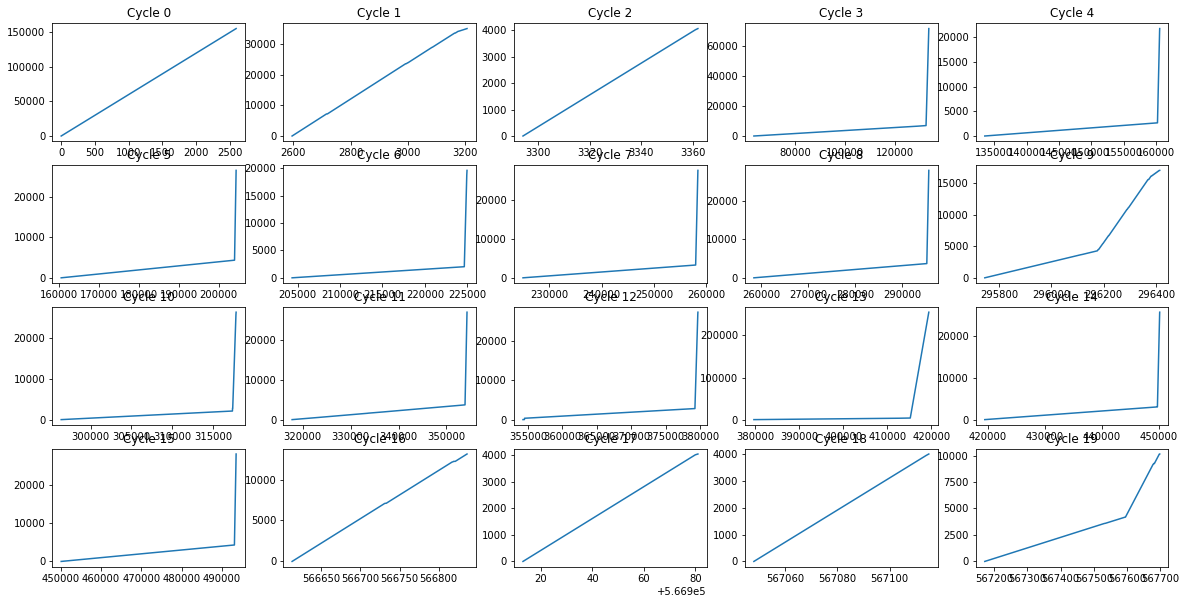

In [18]:
# plot all cycle_data cycle 't' into sub plots
fig, axes = plt.subplots(4, 5, figsize=(20, 10))
for i, ax in enumerate(axes.flatten()):
  if i >= len(cycle_data):
    break
  cycle_data[i]['cycle']['t'].plot(ax=ax)
  ax.set_title(f'Cycle {i}')

In [19]:
caps = []
feats = []

for i in range(len(cycle_data)):
  caps.append(cycle_data[i]['cap'])
  
  cycle = cycle_data[i]['cycle']
  time = cycle['t'].values / 60 # to minutes (align with MIT Stanford dataset)
  current = cycle['Current'].values
  temp = cycle['Temperature'].values
  feat = [
    np.trapz((current == 0).astype(np.float32), time),
    np.trapz((current > 0).astype(np.float32), time),
    np.trapz((current < 0).astype(np.float32), time),
    max(current),
    abs(min(current))
  ]
      
  for t in range(math.floor(min_temp), math.ceil(max_temp), temperature_feature_interval):
    feat = np.append(feat, np.trapz(((temp > t) & (temp <= t+temperature_feature_interval)).astype(np.float32), time))
  # only check charging current (I>0), as the discharge cycles are constant
  for c in range(0, math.ceil(max_current), current_feature_interval):
    feat = np.append(feat, np.trapz(((current > c) & (current <= c+current_feature_interval)).astype(np.float32), time))
  feats.append(feat)

In [20]:
cycle_data[30]['cycle']

,Time Stamp,Step,Status,Prog Time,Step Time,Cycle,Cycle Level,Procedure,Voltage,Current,...,Exp Temperature,Cycle Name,Exp Name,Index,Status Consecutive,Status Unique,Cycle Num,Prog Timestamp,Prog Time Delta,t
917112,3/21/2019 7:12:40 AM,57,TABLE,13:20:33.006,00:00:01.921,1,1,Samsung30T_CyclesB,4.18363,-0.07918,...,25degC,740_Mixed7,25degC: 740_Mixed7,917112,1031,TABLE1031,102.0,-2.208941e+09,0.000,0.000
917113,3/21/2019 7:12:40 AM,57,TABLE,13:20:33.103,00:00:02.018,1,1,Samsung30T_CyclesB,4.18245,-0.18134,...,25degC,740_Mixed7,25degC: 740_Mixed7,917113,1031,TABLE1031,102.0,-2.208941e+09,0.097,0.097
917114,3/21/2019 7:12:40 AM,57,TABLE,13:20:33.207,00:00:02.122,1,1,Samsung30T_CyclesB,4.18177,-0.23242,...,25degC,740_Mixed7,25degC: 740_Mixed7,917114,1031,TABLE1031,102.0,-2.208941e+09,0.104,0.201
917115,3/21/2019 7:12:40 AM,57,TABLE,13:20:33.301,00:00:02.216,1,1,Samsung30T_CyclesB,4.1816,-0.24264,...,25degC,740_Mixed7,25degC: 740_Mixed7,917115,1031,TABLE1031,102.0,-2.208941e+09,0.094,0.295
917116,3/21/2019 7:12:40 AM,57,TABLE,13:20:33.411,00:00:02.326,1,1,Samsung30T_CyclesB,4.18144,-0.24519,...,25degC,740_Mixed7,25degC: 740_Mixed7,917116,1031,TABLE1031,102.0,-2.208941e+09,0.110,0.405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
946769,3/21/2019 9:35:05 AM,11,PAU,15:42:58.310,00:11:00.004,0,0,Slave_charge,4.18596,0.00000,...,25degC,740_Charge15,25degC: 740_Charge15,946769,1034,PAU1034,102.0,-2.208932e+09,60.006,8545.304
946770,3/21/2019 9:36:05 AM,11,PAU,15:43:58.310,00:12:00.004,0,0,Slave_charge,4.18563,0.00000,...,25degC,740_Charge15,25degC: 740_Charge15,946770,1034,PAU1034,102.0,-2.208932e+09,60.000,8605.304
946771,3/21/2019 9:37:05 AM,11,PAU,15:44:58.317,00:13:00.011,0,0,Slave_charge,4.18512,0.00000,...,25degC,740_Charge15,25degC: 740_Charge15,946771,1034,PAU1034,102.0,-2.208932e+09,60.007,8665.311
946772,3/21/2019 9:38:05 AM,11,PAU,15:45:58.313,00:14:00.007,0,0,Slave_charge,4.18478,0.00000,...,25degC,740_Charge15,25degC: 740_Charge15,946772,1034,PAU1034,102.0,-2.208932e+09,59.996,8725.307


In [21]:
for t in cycle_data[30]['cycle']['t'].values / 60:
  print(t)

0.0
0.001616668701171875
0.0033499956130981444
0.004916667938232422
0.006749995549519857
0.008283329010009766
0.010066668192545572
0.011616667111714682
0.013199996948242188
0.014983336130777994
0.016733336448669433
0.01833333174387614
0.019899996121724446
0.02156666914621989
0.02326666514078776
0.0250499963760376
0.026833335558573406
0.028199998537699382
0.030000003178914388
0.03155000209808349
0.03333333333333333
0.03486666679382324
0.03674999872843424
0.03826666673024495
0.039983336130777994
0.041550000508626304
0.043400001525878903
0.044916669527689614
0.04671666622161865
0.048366665840148926
0.05006666978200277
0.051566664377848306
0.05326666831970215
0.05500000317891439
0.056766668955485024
0.0584000031153361
0.05991666316986084
0.06163333257039388
0.06333333651224772
0.0650499979654948
0.0665333350499471
0.06823333104451497
0.06995000044504801
0.07170000076293945
0.07339999675750733
0.07491666475931803
0.07664999961853028
0.07833333015441894
0.08006666501363119
0.0815833330154418

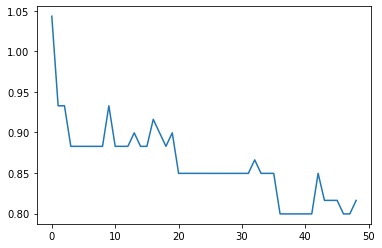

In [22]:
plt.plot(caps)

In [23]:
pre_processed_data = {
  'driving_cycle': {
    'capacities': torch.tensor(np.array(caps), dtype=torch.float32),
    'features': torch.tensor(np.array(feats), dtype=torch.float32)
  }
}

os.makedirs('./Samsung INR21700 30T 3Ah Li-ion Battery Data', exist_ok=True)
pickle.dump(pre_processed_data, open('./Samsung INR21700 30T 3Ah Li-ion Battery Data/preprocessed_data.pkl', 'wb'))